<a href="https://colab.research.google.com/github/Mita3055/Gittest/blob/main/DIW_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import csv

In [5]:
# Input Paramititers

time_step = 0.01

X_testing = 65
Y_testing = 76
Z_testing = 127
F_testing = 200
E_Starting = (np.random.uniform(15, 56))
E_move = 47.8

dispencse_start = 34
dispence_time = 57.30
time_wait = 12.36
ink_density = 0.195 # g/ml
dispence_volume = 5 # ml
dispence_mass = ink_density * dispence_volume

time_end = dispencse_start + dispence_time + time_wait

ink = "Pure MXene Ink (40mg/ml)"

feed_rates = [100, 200, 300, 400, 500, 600, 700]
ink_dispence_times = [150, 120, 100, 90, 70, 50, 30] #seconds
steps = [1, 12, 13, 25, 28, 30, 70] # in mass step function





In [7]:
# (Time : linear) (X, Y, Z: constant)

time_data = np.arange(0, time_end + time_step, time_step)
X_data = np.full_like(time_data, X_testing)
Y_data = np.full_like(time_data, Y_testing)
Z_data = np.full_like(time_data, Z_testing)

data = {'Time': time_data, 'X': X_data, 'Y': Y_data, 'Z': Z_data}
df = pd.DataFrame(data)

In [8]:
# E Columbs linear advance durring dispence constant else where

E_data = []
for t in time_data:
    if t < dispencse_start:
        E_data.append(E_Starting)
    elif t < dispencse_start + dispence_time:
        # Linear interpolation
        E_value = E_Starting + (E_move * (t - dispencse_start) / dispence_time)
        E_data.append(E_value)
    else:
        E_data.append(E_Starting + E_move)

df['E'] = E_data


In [10]:
F_data = []
dispensing_data = []
printer_status_data = [] # New list for printer status
time_tare = np.random.uniform(11, 12)  # random number between 11-12

for t in time_data:
    if t < time_tare: # Before taring
        F_data.append(0)
        dispensing_data.append(False)
        printer_status_data.append("None")
    elif time_tare <= t < time_tare + np.random.uniform(0.5, 1.5): # During taring and before dispensing
        F_data.append(0)
        dispensing_data.append(False)
        printer_status_data.append("Tarring") # Add Tarring status
    elif dispencse_start <= t < dispencse_start + dispence_time: # During dispensing
        F_data.append(F_testing)
        dispensing_data.append(True)
        printer_status_data.append("Dispensing") # Change status to Dispensing
    else: # After dispensing
        F_data.append(0)
        dispensing_data.append(False)
        printer_status_data.append("None") # Status after dispensing

df['F'] = F_data
df['Dispensing'] = dispensing_data
df['PRINTER_STATUS'] = printer_status_data # Add the new column to the DataFrame

In [11]:
# Scale mass data generation
m_start = np.random.uniform(0.5, 2)  # starting weight pre-taring random number between 0.5&2 grams
m_noise_factor = 0.03  # noise factor for data set
noise_probability = 0.2  # Probability of applying noise to any given point (30% of points)

m_steps = 12  # Steps in step function

# Time when mass reaches final target (3-6s after dispensing ends)
mass_final_time = dispencse_start + dispence_time + np.random.uniform(3, 6)

mass_data = []

# Generate step heights for the dispensing period (reaching ~80% of target)
dispensing_mass_portion = 1* dispence_mass  # Most mass during dispensing
remaining_mass_portion = dispence_mass - dispensing_mass_portion  # Rest after dispensing

# Create random step heights that sum to dispensing_mass_portion
step_heights = np.random.dirichlet(np.ones(m_steps)) * dispensing_mass_portion
step_times = np.linspace(dispencse_start, dispencse_start + dispence_time, m_steps + 1)

for t in time_data:
    if t < time_tare:
        # Before taring: show initial weight
        base_mass = m_start
    elif t < dispencse_start:
        # After taring, before dispensing: should be 0
        base_mass = 0
    elif t < dispencse_start + dispence_time:
        # During dispensing: step function
        # Find which step we're in
        step_index = np.searchsorted(step_times[1:], t)
        step_index = min(step_index, m_steps - 1)  # Ensure we don't exceed array bounds

        # Calculate cumulative mass up to current step
        base_mass = np.sum(step_heights[:step_index + 1])
    elif t < mass_final_time:
        # After dispensing but before reaching final mass: linear increase
        time_since_dispense_end = t - (dispencse_start + dispence_time)
        total_time_to_final = mass_final_time - (dispencse_start + dispence_time)

        # Linear interpolation from end-of-dispensing mass to final mass
        progress = time_since_dispense_end / total_time_to_final
        base_mass = dispensing_mass_portion + (remaining_mass_portion * progress)
    else:
        # After reaching final time: stays at target mass
        base_mass = dispence_mass

    # Add noise selectively - only to random points
    if np.random.random() < noise_probability:
        noise = np.random.normal(0, m_noise_factor)
        mass_with_noise = max(0, base_mass + noise)
    else:
        mass_with_noise = base_mass

    mass_data.append(mass_with_noise)

df['SCALE_READING_GRAMM'] = mass_data

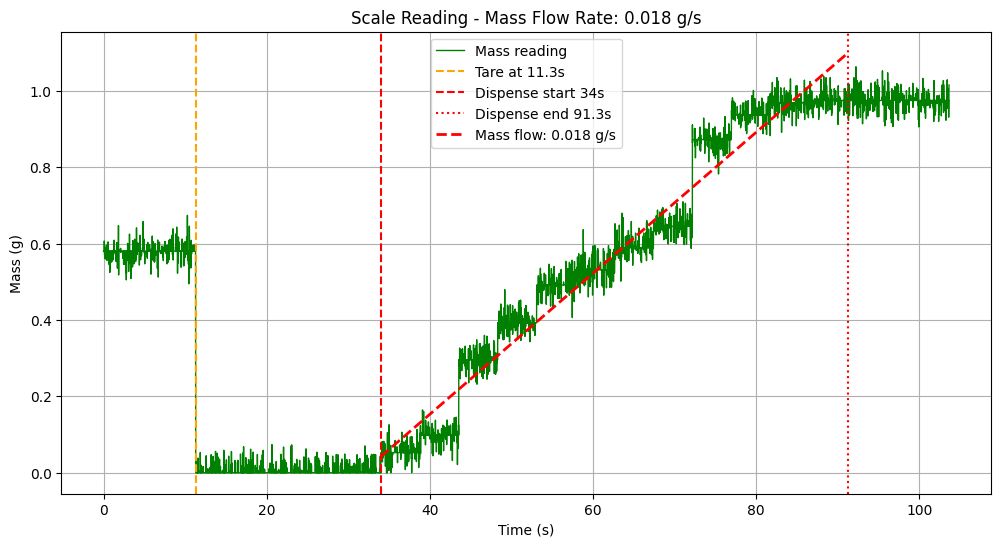

Mass flow rate during dispensing: 0.0185 g/s
Total dispensed mass: 0.9750000000000001 g
Theoretical flow rate: 0.0170 g/s


In [12]:
# Mass data visualization
plt.figure(figsize=(12, 6))

# Plot Mass
plt.plot(df['Time'], df['SCALE_READING_GRAMM'], 'g-', linewidth=1.0, label='Mass reading')
plt.axvline(x=time_tare, color='orange', linestyle='--', label=f'Tare at {time_tare:.1f}s')
plt.axvline(x=dispencse_start, color='red', linestyle='--', label=f'Dispense start {dispencse_start}s')
plt.axvline(x=dispencse_start + dispence_time, color='red', linestyle=':', label=f'Dispense end {dispencse_start + dispence_time}s')

# Fit slope to dispensing section and calculate mass flow
dispense_mask = (df['Time'] >= dispencse_start) & (df['Time'] <= dispencse_start + dispence_time)
dispense_time_data = df.loc[dispense_mask, 'Time'].values
dispense_mass_data = df.loc[dispense_mask, 'SCALE_READING_GRAMM'].values

# Linear regression for mass flow
slope, intercept = np.polyfit(dispense_time_data, dispense_mass_data, 1)
mass_flow = slope  # g/s

# Plot fitted line
fitted_line = slope * dispense_time_data + intercept
plt.plot(dispense_time_data, fitted_line, 'r--', linewidth=2, label=f'Mass flow: {mass_flow:.3f} g/s')

plt.xlabel('Time (s)')
plt.ylabel('Mass (g)')
plt.title(f'Scale Reading - Mass Flow Rate: {mass_flow:.3f} g/s')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mass flow rate during dispensing: {mass_flow:.4f} g/s")
print(f"Total dispensed mass: {dispence_mass} g")
print(f"Theoretical flow rate: {dispence_mass/dispence_time:.4f} g/s")

In [102]:
# CSV File Settings
timestamp = datetime.now().strftime("%d_%H%M%S")
file_name = "results"+timestamp


# Save to CSV
# Round all numerical columns to 2 decimal places
df.round(2).to_csv(file_name + '.csv', index=False)

display(df.head())

,Time,X,Y,Z,E,F,Dispensing,PRINTER_STATUS,SCALE_READING_GRAMM
0,0.00,65.0,76.0,127.0,1.5,0,False,None,0.732332
1,0.01,65.0,76.0,127.0,1.5,0,False,None,0.729787
2,0.02,65.0,76.0,127.0,1.5,0,False,None,0.732332
3,0.03,65.0,76.0,127.0,1.5,0,False,None,0.731826
4,0.04,65.0,76.0,127.0,1.5,0,False,None,0.732332


## Add noise

### Subtask:
Apply a noise factor (`m_noise_factor`) to the generated mass data.